<a href="https://colab.research.google.com/github/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers Library

In [2]:
# !pip install transformers
# !pip install datasets

In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [10]:
!pwd

/Text_Extraction/Shishir - MISC


# Load Dataset

In [11]:
# from datasets import load_dataset

# dataset = load_dataset("BEE-spoke-data/consumer-finance-complaints")

from datasets import load_dataset

dataset = load_dataset("ccdv/patent-classification",cache_dir="/Text_Extraction/Shishir - MISC/Data")

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for ccdv/patent-classification contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ccdv/patent-classification
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [12]:
subjects={
          0:"Human Necessities",
          1:"Performing Operations; Transporting",
          2:"Chemistry; Metallurgy",
          3:"Textiles; Paper",
          4:"Fixed Constructions",
          5:"Mechanical Engineering; Lightning; Heating; Weapons; Blasting",
          6:"Physics",
          7:"Electricity",
          8:"General tagging of new or cross-sectional technology"
         }

In [13]:
cnt_arr=[]

for i in dataset['train']:
    cnt=len(i['text'].split())
    cnt_arr.append(cnt)
    
    

In [14]:
max(cnt_arr)

83624

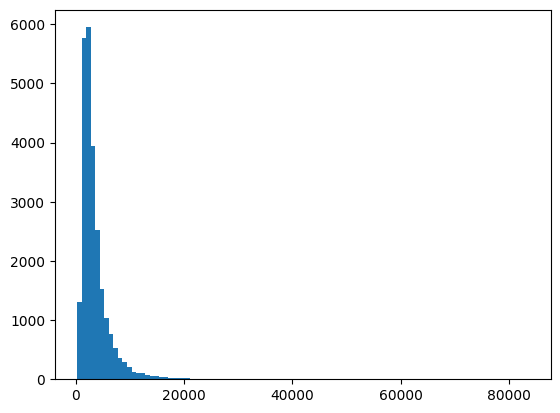

In [15]:
## plotting the text length
import matplotlib.pyplot as plt
plt.hist(cnt_arr,bins=100);

In [16]:
# from datasets import load_dataset
# emotions = load_dataset("emotion")


In [17]:
# !pip install sentence_transformers

In [18]:
## Extractive summarization 
# from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F
from torch.nn.parallel import DataParallel
from tqdm import tqdm
import os
# Optionally set the cache directory for transformers
os.environ['TRANSFORMERS_CACHE'] = "/Text_Extraction/Shishir - MISC/Sentence_Trans"



In [19]:
# import os
# import numpy as np
# import torch
# from tqdm import tqdm
# from sentence_transformers import SentenceTransformer
# from torch.nn.parallel import DataParallel

# # Optionally set the cache directory for transformers
# os.environ['TRANSFORMERS_CACHE'] = "/Text_Extraction/Shishir - MISC/Sentence_Trans"

# # Initialize the model
# model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# model = model.cuda()  # Move the model to GPU
# # model = DataParallel(model)  # Wrap the model with DataParallel

# # Define a function to encode sentences in batches
# def encode_sentences_in_batches(model, sentences, batch_size=16):
#     all_embeddings = []
#     for i in range(0, len(sentences), batch_size):
#         batch = sentences[i:i+batch_size]
#         with torch.no_grad():
#             embeddings = model.encode(batch, convert_to_tensor=True, device='cuda')
#         all_embeddings.append(embeddings.cpu().numpy())
#     return np.vstack(all_embeddings)

# # Process the dataset
# first_1000_examples = dataset['train'].select(range(1000))

# for i in tqdm(first_1000_examples):
#     sentences = i['text'].split(". ")
#     n_sent = len(sentences)
#     chunks = []

#     ind = 0
#     cur_sent = ""
#     ln = 0

#     while ind < n_sent:
#         if ln <= 300:
#             cur_sent += sentences[ind]
#             ln += len(sentences[ind].split())
#             ind += 1
#         elif ln > 300:
#             chunks.append(cur_sent)
#             ln = 0
#             cur_sent = sentences[ind]
#             ln += len(cur_sent.split())
#             ind += 1
#         elif ind == n_sent - 1:
#             cur_sent += sentences[ind]
#             chunks.append(cur_sent)
#             ind += 1

#     # Compute token embeddings for chunks
#     chunk_embeddings = encode_sentences_in_batches(model, chunks)
#     chunk_embedding = np.mean(chunk_embeddings, axis=0)

#     model_output_sent = []

#     # Compute embeddings for each sentence
#     sentence_embeddings = encode_sentences_in_batches(model, sentences)

#     for ind_s, embedding in enumerate(sentence_embeddings):
#         model_output_sent.append((ind_s, embedding))

#     # Now you have model_output_sent which contains sentence embeddings


In [130]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from torch.nn.parallel import DataParallel

# Optionally set the cache directory for transformers
os.environ['TRANSFORMERS_CACHE'] = "/Text_Extraction/Shishir - MISC/Sentence_Trans"

# Initialize the model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
model = model.cuda()  # Move the model to GPU
# model = DataParallel(model)  # Wrap the model with DataParallel

# Define a function to encode sentences in batches
def encode_sentences_in_batches(model, sentences, batch_size=16):
    all_embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        with torch.no_grad():
            embeddings = model.encode(batch, convert_to_tensor=True, device='cuda')
        all_embeddings.append(embeddings.cpu().numpy())
    return np.vstack(all_embeddings)

# Process the dataset
second_5000_examples = dataset['train'].select(range(5000, 10000))

top_sentences = []

for i in tqdm(second_5000_examples):
    sentences = i['text'].split(". ")
    n_sent = len(sentences)
    chunks = []

    ind = 0
    cur_sent = ""
    ln = 0

    while ind < n_sent:
        if ln <= 300:
            cur_sent += sentences[ind] + ". "
            ln += len(sentences[ind].split())
            ind += 1
        elif ln > 300:
            chunks.append(cur_sent.strip())
            ln = 0
            cur_sent = sentences[ind] + ". "
            ln += len(cur_sent.split())
            ind += 1
        elif ind == n_sent - 1:
            cur_sent += sentences[ind]
            chunks.append(cur_sent.strip())
            ind += 1
    try:
        # Compute token embeddings for chunks
        chunk_embeddings = encode_sentences_in_batches(model, chunks)
        chunk_embedding = np.mean(chunk_embeddings, axis=0)
    
        # Compute embeddings for each sentence
        sentence_embeddings = encode_sentences_in_batches(model, sentences)
    
        # Calculate cosine similarities
        chunk_embedding_tensor = torch.tensor(chunk_embedding).cuda()
        sent_embeddings_tensor = torch.tensor(sentence_embeddings).cuda()
        cosine_similarities = F.cosine_similarity(sent_embeddings_tensor, chunk_embedding_tensor.unsqueeze(0), dim=1)
    
        # Index and sort embeddings by similarity
        indexed_embeddings = [(ind_s, cosine_similarities[ind_s].item()) for ind_s in range(len(sentences))]
        indexed_embeddings.sort(key=lambda x: x[1], reverse=True)  # Sort by cosine similarity score in decreasing order
    
        # Select top k sentences based on similarity score
        top_k = min(len(indexed_embeddings), 15)
        indexed_embeddings = indexed_embeddings[:top_k]
        
        top_sent = [(sentences[index], scr,index) for index, scr in indexed_embeddings]
        top_sentences.append(top_sent)
        
    except:
        top_sentences.append([])
        

# Now you have top_sentences which contains the top sentences based on similarity scores


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [31:39<00:00,  2.63it/s]


In [131]:
file_path = '/Text_Extraction/Shishir - MISC/top_sentences.txt'


with open(file_path, 'a') as file:
    for item in top_sentences:
        file.write(f"{item}\n")

In [141]:
import ast

# Define the path to your text file
file_path = '/Text_Extraction/Shishir - MISC/top_sentences.txt'


# Initialize an empty list to store the tuples
top_sentences_new = []

# Read and parse the file
with open(file_path, 'r') as file:
    for line in file:
        # Strip leading and trailing whitespace characters from the line
        line = line.strip()
        if line:  # Check if the line is not empty
            # Convert the string representation of the tuple to an actual tuple
            tuple_data = ast.literal_eval(line)
            # Append the tuple to the list
            top_sentences_new.append(tuple_data)



In [142]:
# top_sentences[0].sort(key=lambda x:x[2])
labels=[] ### labels for texts

for i in tqdm(dataset['train'].select(range( 10000))):
    labels.append(i['label'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 29120.78it/s]


In [143]:
len(top_sentences_new),len(labels)

(10000, 10000)

In [199]:
txt_lbl=[]

with open(file_path, 'r') as file:
    for i,line in enumerate(file):
        # Strip leading and trailing whitespace characters from the line
        line = line.strip()
        txt_lbl.append((line,labels[i]))

file_path = '/Text_Extraction/Shishir - MISC/top_sentences_new.txt'


with open(file_path, 'a') as file:
    for item in txt_lbl:
        file.write(f"{item}\n")
        

In [30]:
# check class distribution
from collections import Counter

label_counts = Counter(labels)
    
# Calculate the total number of elements
total_count = len(labels)

# Calculate the percentage of each unique value
label_percentages = {label: round((count / total_count) * 100,2) for label, count in label_counts.items()}


In [31]:
label_percentages

{6: 21.88,
 0: 14.8,
 7: 21.08,
 8: 9.92,
 2: 8.2,
 4: 3.02,
 1: 13.3,
 3: 0.78,
 5: 7.02}

# Split train dataset into train, validation and test sets

In [144]:
# Create indices for each data point
indices = list(range(len(top_sentences_new)))

# Split the data into train and temporary sets
train_text, temp_text, train_labels, temp_labels, train_indices, temp_indices = train_test_split(
    top_sentences_new, labels, indices,
    random_state=2018,
    test_size=0.1,
    stratify=labels
)

# Split the temporary set into validation and test sets
val_text, test_text, val_labels, test_labels, val_indices, test_indices = train_test_split(
    temp_text, temp_labels, temp_indices,
    random_state=2018,
    test_size=0.5,
    stratify=temp_labels
)


In [146]:
len(train_indices)

9000

In [147]:
train_text_new,train_labels_new=[],[]
for ind,(txt, lbl) in enumerate(zip(train_text,train_labels)):

    if txt:
        ln=0
        tmp=[]

        index=0
        while index<len(txt) and ln<=320 :
            cur_len=len(txt[index][0].split())
            ln+=cur_len
            tmp.append(txt[index])
            index+=1
 
        tmp.sort(key=lambda x: x[2])
        
        tmp=[i[0] for i in tmp] 
        train_text_new.append(". ".join(tmp))
        train_labels_new.append(lbl)

############################## Validation texts ##############################

val_text_new,val_labels_new=[],[]
for ind,(txt, lbl) in enumerate(zip(val_text,val_labels)):

    if txt:
        ln=0
        tmp=[]

        index=0
        while index<len(txt) and ln<=320 :
            cur_len=len(txt[index][0].split())
            ln+=cur_len
            tmp.append(txt[index])
            index+=1
 
        tmp.sort(key=lambda x: x[2])
        
        tmp=[i[0] for i in tmp] 
        val_text_new.append(". ".join(tmp))
        val_labels_new.append(lbl)        

################################ Test texts #####################################

test_text_new,test_labels_new=[],[]
for ind,(txt, lbl) in enumerate(zip(test_text,test_labels)):

    if txt:
        ln=0
        tmp=[]

        index=0
        while index<len(txt) and ln<=320 :
            cur_len=len(txt[index][0].split())
            ln+=cur_len
            tmp.append(txt[index])
            index+=1
 
        tmp.sort(key=lambda x: x[2])
        
        tmp=[i[0] for i in tmp] 
        test_text_new.append(". ".join(tmp))
        test_labels_new.append(lbl)       

In [148]:
len(test_text_new)

500

# Import BERT Model and BERT Tokenizer

In [149]:
# !pip install sentencepiece
len(train_text_new)

8998

In [180]:
# import BERT-base pretrained model
from transformers import AutoTokenizer,AutoModel,AutoModelForMaskedLM,RobertaModel
from transformers import RobertaForSequenceClassification

# model_ckpt = "cardiffnlp/twitter-roberta-base-sentiment-latest"
model_ckpt="distilbert/distilbert-base-uncased-finetuned-sst-2-english"
# "FacebookAI/roberta-base"
# "google/bigbird-roberta-base"

from transformers import BigBirdModel
# model = BigBirdModel.from_pretrained("google/bigbird-roberta-base")

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
bert = AutoModel.from_pretrained(model_ckpt,cache_dir="/Text_Extraction/Shishir - MISC/Distilbert_sst2_models/")



/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [181]:
# bert

# Tokenization

<Axes: >

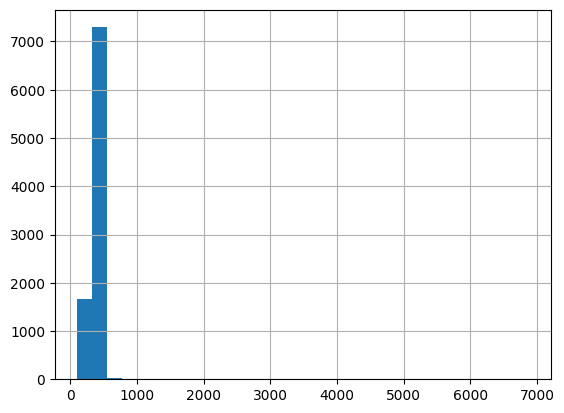

In [182]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text_new]

pd.Series(seq_len).hist(bins = 30)

In [183]:
max_seq_len = 512

In [184]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text_new,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text_new,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text_new,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [185]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels_new)

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels_new)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels_new)

# Create DataLoaders

In [186]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 128

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [187]:
# freeze all the parameters
layers_unfrozen=[
                # "layer.5.ffn.lin2",
    "layer.5.output_layer_norm"
                 # "layer.5"
]
# ["pooler","encoder.layer.11.output"]

for name, param in bert.named_parameters():
    frozen=True
    for nm in layers_unfrozen:
        if nm in name:
            param.requires_grad = True
            frozen=False
            break

    if  frozen:
        param.requires_grad = False
        
            

In [188]:
# Verify which parameters are frozen and which are not
for name, param in bert.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

# # Alternatively, you can filter and display only the unfrozen parameters to make it easier to check
# print("\nUnfrozen parameters:")
# for name, param in bert.named_parameters():
#     if param.requires_grad:
#         print(f"{name}: requires_grad={param.requires_grad}")


embeddings.word_embeddings.weight: requires_grad=False
embeddings.position_embeddings.weight: requires_grad=False
embeddings.LayerNorm.weight: requires_grad=False
embeddings.LayerNorm.bias: requires_grad=False
transformer.layer.0.attention.q_lin.weight: requires_grad=False
transformer.layer.0.attention.q_lin.bias: requires_grad=False
transformer.layer.0.attention.k_lin.weight: requires_grad=False
transformer.layer.0.attention.k_lin.bias: requires_grad=False
transformer.layer.0.attention.v_lin.weight: requires_grad=False
transformer.layer.0.attention.v_lin.bias: requires_grad=False
transformer.layer.0.attention.out_lin.weight: requires_grad=False
transformer.layer.0.attention.out_lin.bias: requires_grad=False
transformer.layer.0.sa_layer_norm.weight: requires_grad=False
transformer.layer.0.sa_layer_norm.bias: requires_grad=False
transformer.layer.0.ffn.lin1.weight: requires_grad=False
transformer.layer.0.ffn.lin1.bias: requires_grad=False
transformer.layer.0.ffn.lin2.weight: requires_gr

# Define Model Architecture

In [189]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 9)
        self.softmax = nn.LogSoftmax(dim=1)

        self.weight_decay = 0.01

    def forward(self, sent_id, mask):
        # Pass the inputs to the model
        outputs = self.bert(sent_id, attention_mask=mask)
        
        # Use pooler_output if available, else fall back to cls token
        cls_hs = outputs.pooler_output if 'pooler_output' in outputs else outputs.last_hidden_state[:, 0, :]
        x=self.dropout(cls_hs)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # x = self.dropout(x)

        x = self.softmax(x)

        return x

In [190]:
device

device(type='cuda')

In [191]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)


from torch.nn.parallel import DataParallel
# If you have more than one GPU available, wrap the model with DataParallel
if torch.cuda.device_count() > 1:
    model = DataParallel(model)
    print("True")


True


In [192]:
model

DataParallel(
  (module): BERT_Arch(
    (bert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
              (dropout

In [193]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-4,weight_decay=0.03)

# optimizer = optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=self.weight_decay)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Find Class Weights

In [194]:
from sklearn.utils.class_weight import compute_class_weight


# Compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_new), y=train_labels_new)

print(class_wts)


[ 0.7494586   0.84298295  1.26075382 14.28253968  4.09744991  1.62830257
  0.51534937  0.52926298  1.07734674]


In [195]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 200

# Fine-Tune BERT

In [196]:
def train():
    model.train()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(tqdm(train_dataloader)):
        if step % 10 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        batch = [r.to('cuda') for r in batch]  # Ensure data is on the right device
        sent_id, mask, labels = batch

        model.zero_grad()

        preds = model(sent_id, mask)

        loss = cross_entropy(preds, labels)
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.5)
        optimizer.step()

        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [197]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [198]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.96it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.96it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.96it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.94it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.91it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:03,  3.43it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.89it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 2.131
Validation Loss: 2.016

 Epoch 2 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.94it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.93it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.92it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.90it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.90it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.88it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.94it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.970
Validation Loss: 1.849

 Epoch 3 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.90it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.91it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.87it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.88it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.87it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.90it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.92it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.847
Validation Loss: 1.776

 Epoch 4 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.86it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.87it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.85it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:08,  3.86it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.90it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.92it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.92it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.772
Validation Loss: 1.692

 Epoch 5 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.93it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.94it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.91it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.90it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.91it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.91it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.94it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.711
Validation Loss: 1.655

 Epoch 6 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.88it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.86it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.89it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.88it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.90it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.87it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.92it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.686
Validation Loss: 1.616

 Epoch 7 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.86it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.85it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.91it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:08,  3.86it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.85it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.85it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.90it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.638
Validation Loss: 1.597

 Epoch 8 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.87it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.87it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.86it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:08,  3.85it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.85it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.87it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.90it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.616
Validation Loss: 1.583

 Epoch 9 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.89it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.88it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.91it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.89it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.86it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.90it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.93it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.597
Validation Loss: 1.556

 Epoch 10 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.92it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.87it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.90it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.89it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.87it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.86it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.92it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.571
Validation Loss: 1.517

 Epoch 11 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.89it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.89it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.90it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:08,  3.87it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.84it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.90it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.92it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.548
Validation Loss: 1.489

 Epoch 12 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.93it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.90it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.91it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.90it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.92it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.91it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.94it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.532
Validation Loss: 1.491

 Epoch 13 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.87it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.84it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.91it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.89it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.87it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.85it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.91it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.509
Validation Loss: 1.476

 Epoch 14 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.90it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.88it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.91it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.88it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.89it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.88it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.92it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.497
Validation Loss: 1.458

 Epoch 15 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.88it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.88it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.88it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:08,  3.82it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:13<00:05,  3.64it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.77it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.84it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.480
Validation Loss: 1.487

 Epoch 16 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.92it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.91it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.93it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.92it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.93it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.92it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.96it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.469
Validation Loss: 1.444

 Epoch 17 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.93it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.95it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.94it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.95it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.94it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.96it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.98it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.466
Validation Loss: 1.467

 Epoch 18 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.95it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.87it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.91it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.92it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.93it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.92it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.96it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.461
Validation Loss: 1.466

 Epoch 19 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.88it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.85it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.90it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:08,  3.82it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.93it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.93it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.93it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.462
Validation Loss: 1.421

 Epoch 20 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.82it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.68it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.77it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:08,  3.81it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:13<00:05,  3.75it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.72it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.80it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.442
Validation Loss: 1.415

 Epoch 21 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:16,  3.75it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.81it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:11,  3.71it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:08,  3.68it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:13<00:05,  3.72it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:16<00:02,  3.75it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.78it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.437
Validation Loss: 1.441

 Epoch 22 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:16,  3.81it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.91it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.89it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.92it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.92it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.95it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.94it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.441
Validation Loss: 1.433

 Epoch 23 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.94it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.94it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.93it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.93it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.92it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.93it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.96it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.422
Validation Loss: 1.436

 Epoch 24 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.93it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.93it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.90it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.93it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.89it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.90it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.95it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.428
Validation Loss: 1.419

 Epoch 25 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.93it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.92it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.94it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.94it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.94it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.94it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.97it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.412
Validation Loss: 1.409

 Epoch 26 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.95it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.92it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.93it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.94it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.95it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.91it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.97it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.398
Validation Loss: 1.420

 Epoch 27 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.95it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.93it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.93it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.94it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.95it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.92it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.97it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.394
Validation Loss: 1.413

 Epoch 28 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.97it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.97it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.95it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:08,  3.66it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.94it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.94it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.93it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.394
Validation Loss: 1.410

 Epoch 29 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.93it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.91it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.92it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.91it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.91it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.89it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.95it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.389
Validation Loss: 1.416

 Epoch 30 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.91it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.93it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.91it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.91it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.94it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.93it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.96it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.379
Validation Loss: 1.433

 Epoch 31 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.94it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.95it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.95it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.92it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.94it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.92it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.97it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.383
Validation Loss: 1.380

 Epoch 32 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.94it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.93it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.93it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.93it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.93it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.89it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.96it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.376
Validation Loss: 1.426

 Epoch 33 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.93it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.89it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.93it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.90it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.92it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.94it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.96it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.381
Validation Loss: 1.396

 Epoch 34 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.94it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.94it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.93it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.92it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.94it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.92it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.97it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.371
Validation Loss: 1.437

 Epoch 35 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.91it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.92it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.92it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.94it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.92it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.94it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.96it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.380
Validation Loss: 1.387

 Epoch 36 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.87it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.92it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.89it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.93it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.90it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.94it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.96it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.362
Validation Loss: 1.391

 Epoch 37 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.95it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.94it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.95it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.95it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.90it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.94it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.97it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.356
Validation Loss: 1.390

 Epoch 38 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.94it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.95it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.96it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.95it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.96it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.94it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.98it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.357
Validation Loss: 1.437

 Epoch 39 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.92it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.92it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.95it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:09,  3.14it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:13<00:05,  3.89it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.93it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.90it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.341
Validation Loss: 1.442

 Epoch 40 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.94it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.90it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.93it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.91it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.92it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.91it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.95it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.344
Validation Loss: 1.399

 Epoch 41 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.93it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.92it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.92it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.90it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.92it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.90it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.95it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.362
Validation Loss: 1.413

 Epoch 42 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.95it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.91it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.92it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.89it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.89it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.91it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.95it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.339
Validation Loss: 1.496

 Epoch 43 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.91it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.91it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.93it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.91it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.93it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.88it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.94it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.353
Validation Loss: 1.409

 Epoch 44 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.92it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.93it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.94it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.93it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.93it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.94it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.96it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.338
Validation Loss: 1.411

 Epoch 45 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.94it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.96it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.93it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.95it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.93it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.94it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.98it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.332
Validation Loss: 1.401

 Epoch 46 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.95it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.96it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.95it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.96it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.92it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.95it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.98it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.337
Validation Loss: 1.408

 Epoch 47 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:20,  2.91it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.89it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.92it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.93it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.96it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.93it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.91it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.333
Validation Loss: 1.387

 Epoch 48 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.93it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.95it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.93it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.95it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.96it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.94it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.98it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.348
Validation Loss: 1.383

 Epoch 49 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.94it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.95it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.97it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.93it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.94it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.95it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.98it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.315
Validation Loss: 1.406

 Epoch 50 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.92it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.91it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.92it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.93it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.96it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.93it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.97it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.323
Validation Loss: 1.415

 Epoch 51 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.93it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.94it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.94it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.93it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.91it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.93it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.97it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.331
Validation Loss: 1.386

 Epoch 52 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.94it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.93it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.90it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.95it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.93it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.93it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.97it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.322
Validation Loss: 1.390

 Epoch 53 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.91it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.91it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.87it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.92it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.90it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.91it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.95it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.318
Validation Loss: 1.379

 Epoch 54 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.93it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.95it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.87it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.91it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.86it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.91it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.95it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.320
Validation Loss: 1.431

 Epoch 55 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.93it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.92it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.93it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.92it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.93it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.93it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.96it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.309
Validation Loss: 1.388

 Epoch 56 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.89it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.89it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.90it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.89it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.91it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.93it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.95it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.313
Validation Loss: 1.390

 Epoch 57 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.92it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.92it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.86it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.92it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.94it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.93it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:18<00:00,  3.88it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.324
Validation Loss: 1.388

 Epoch 58 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.88it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:13,  3.83it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.94it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.94it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.95it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.93it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.96it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.297
Validation Loss: 1.400

 Epoch 59 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.95it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.96it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.95it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.95it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.90it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.92it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.97it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.307
Validation Loss: 1.382

 Epoch 60 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.95it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.97it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.96it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.96it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.96it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.96it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.99it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.299
Validation Loss: 1.406

 Epoch 61 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.95it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.96it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.96it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.95it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.96it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.96it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  3.99it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.299
Validation Loss: 1.396

 Epoch 62 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.96it/s]

  Batch    10  of     71.


 28%|████████████████████████████████████▉                                                                                              | 20/71 [00:05<00:12,  3.96it/s]

  Batch    20  of     71.


 42%|███████████████████████████████████████████████████████▎                                                                           | 30/71 [00:07<00:10,  3.96it/s]

  Batch    30  of     71.


 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 40/71 [00:10<00:07,  3.96it/s]

  Batch    40  of     71.


 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 50/71 [00:12<00:05,  3.97it/s]

  Batch    50  of     71.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 60/71 [00:15<00:02,  3.98it/s]

  Batch    60  of     71.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00,  4.00it/s]


  Batch    70  of     71.

Evaluating...

Training Loss: 1.301
Validation Loss: 1.431

 Epoch 63 / 200


 14%|██████████████████▍                                                                                                                | 10/71 [00:02<00:15,  3.98it/s]

  Batch    10  of     71.


 24%|███████████████████████████████▎                                                                                                   | 17/71 [00:04<00:14,  3.76it/s]


KeyboardInterrupt: 

# Load Saved Model

In [246]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [207]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [208]:
# # tokenize and encode sequences in the test set
# tokens_test_1 = tokenizer.batch_encode_plus(
#     [txt_ext],
#     max_length = max_seq_len,
#     pad_to_max_length=True,
#     truncation=True,
#     return_token_type_ids=False
# )

In [209]:
# # for test set
# test_seq1 = torch.tensor(tokens_test_1['input_ids'])
# test_mask1 = torch.tensor(tokens_test_1['attention_mask'])
# test_y1 = torch.tensor([lbl])

In [210]:
# test_seq1
# test_y1
# txt_ext

In [211]:
# # get predictions for test data
# with torch.no_grad():
#   preds = model(test_seq1.to(device), test_mask1.to(device))
#   preds = preds.detach().cpu().numpy()
  
# preds

In [212]:
# preds = np.argmax(preds, axis = 1)
# preds
# print(classification_report(test_y1, preds))

In [214]:
# it=0
# for ind,txt_ext,lbl in zip(test_indices,test_text_new,test_labels_new):
#     print(first_1000_examples[ind]['text'],"\n\n")

#     print(txt_ext)

#     print(lbl)
#     it+=1
    
#     if it==2:
#         break
    
    

In [215]:
subjects={
          0:"Human Necessities",
          1:"Performing Operations; Transporting",
          2:"Chemistry; Metallurgy",
          3:"Textiles; Paper",
          4:"Fixed Constructions",
          5:"Mechanical Engineering; Lightning; Heating; Weapons; Blasting",
          6:"Physics",
          7:"Electricity",
          8:"General tagging of new or cross-sectional technology"
         }

In [216]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.59      0.64      0.61        74
           1       0.40      0.29      0.34        66
           2       0.52      0.63      0.57        41
           3       0.00      0.00      0.00         4
           4       0.11      0.07      0.08        15
           5       0.20      0.23      0.21        35
           6       0.52      0.52      0.52       109
           7       0.64      0.54      0.58       106
           8       0.23      0.34      0.28        50

    accuracy                           0.46       500
   macro avg       0.36      0.36      0.35       500
weighted avg       0.47      0.46      0.46       500



In [218]:
import pandas as pd

# Assuming test_y and preds are your actual and predicted labels, respectively
cross_tab = pd.crosstab(test_y, preds, normalize='index')  # Normalize by row

# To display in percentage format with 0 decimal places
cross_tab_percent = cross_tab.applymap(lambda x: f'{x:.0%}')

# Display the cross-tabulation with percentages
print(cross_tab_percent)


col_0    0    1    2   3   4    5    6    7    8
row_0                                           
0      64%   5%   8%  0%  3%   5%   5%   1%   8%
1      12%  29%  11%  2%  5%  15%   8%   0%  20%
2       5%   0%  63%  0%  2%   2%   7%   2%  17%
3      25%  25%  25%  0%  0%   0%   0%   0%  25%
4      27%  13%   0%  0%  7%  27%   0%  13%  13%
5      11%  11%   9%  0%  3%  23%   9%  14%  20%
6       8%   8%   0%  0%  0%   2%  52%  19%  10%
7       2%   1%   6%  0%  0%   5%  25%  54%   8%
8       6%  14%   2%  0%  2%  14%  24%   4%  34%


/tmp/ipykernel_158924/832908819.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cross_tab_percent = cross_tab.applymap(lambda x: f'{x:.0%}')
